# Convolutional Neural Networks
From previous lecture, we successfully classified image data using only flattening. However, when we consider more complex and "unstandardized" images, flattening approach will not succeed, because the object that determines the class of the image can be positioned various locations and various lighting conditions. In order to overcome this issue, we shall inspect the relationship between the pixels insted of sequential values. 
<br><br>
We will use the dataset below in this example. <br>
https://www.kaggle.com/chetankv/dogs-cats-images

## Convolution Layers
Kernels are filters that extracts the relationship between adjacent pixels. For a detailed demonstration and explanation you can visit: <br> https://setosa.io/ev/image-kernels/ <br>
Convolution layers are the processors that cover given inputs with kernels, and create output layers.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms, utils

import cv2

import numpy as np

from matplotlib import pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

**Loading the image**

In [ ]:
# Load image to the memory
image = cv2.imread(r'C:/Users/beyza/Downloads/archive (1)/dataset/training_set/cats/cat.50.jpg')

# As cv2 library loads image in BGR color schema, we need to convert it to RGB in order to visualize in matplotlib.
# If you use cv2.imshow() method you do not do that step. However, that method results Jupyter to crash.
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Show image
plt.imshow(image)
plt.show()

print(image.shape)

**Applying Convolution**

In [ ]:
# Get how many channels image contains, in this case 3 -> R(ed) G(reen) B(lue)
nb_channels = image.shape[2]
output_channels = 1

# Convert image from NumPy/CV2 to Torch Tensor.
# As a side note, in Torch Tensors data is structured as
# (BatchSize, ChannelSize, YSize, XSize)
# Whereas, in CV2/NumPy data is is structured as
# (BatchSize, YSize, XSize)
# So we need to change the dimension of the data either using .transpose() method
# in NumPy or .permute() method in Torch.

image_tensor = torch.from_numpy(image.astype(np.float32)).permute(2,0,1)

# For the purpose of demonstration we define our own kernel weights
# However, they are assigned randomly for training purposes. So you will
# not have to repeat this step when training a neural network.

weights = torch.tensor([[-1., 0., 1.],
                        [-1., 0., 1.],
                        [-1., 0., 1.]])
weights = weights.view(1,1, 3, 3).repeat(output_channels,nb_channels, 1, 1)

# We 'forward' the input to get the output of the convolution process.

output = F.conv2d(image_tensor.unsqueeze_(0), weights)
output_image = output[0].permute(1, 2, 0).numpy()

plt.imshow(output_image, cmap='binary')
plt.show()

print(output_image.shape)

You can observe that size of the image decreases by 2 pixel from both dimensions. It is because convolution takes the middle point of the kernel as the output pixel. As the kernel has dimensions of 3x3 the edge pixels can not be included in the output.
<br>
Output dimensions can be adjusted using **stride and padding**. For further reading you can utilize the source below: <br>
https://towardsdatascience.com/covolutional-neural-network-cb0883dd6529

### Exercise 1
Apply "outline" kernel filter to the image above

In [ ]:
nb_channels = image.shape[2]
output_channels = 1

# Convert image from NumPy/CV2 to Torch Tensor.
# As a side note, in Torch Tensors data is structured as
# (BatchSize, ChannelSize, YSize, XSize)
# Whereas, in CV2/NumPy data is is structured as
# (BatchSize, YSize, XSize)
# So we need to change the dimension of the data either using .transpose() method
# in NumPy or .permute() method in Torch.

image_tensor = torch.from_numpy(image.astype(np.float32)).permute(2,0,1)

# For the purpose of demonstration we define our own kernel weights
# However, they are assigned randomly for training purposes. So you will
# not have to repeat this step when training a neural network.

weights2 = torch.tensor([[-1., -1., -1.],
                        [-1., 8., -1.],
                        [-1., -1., -1.]])
weights2 = weights2.view(1,1, 3, 3).repeat(output_channels,nb_channels, 1, 1)

# We 'forward' the input to get the output of the convolution process.

output = F.conv2d(image_tensor.unsqueeze_(0), weights2)
output_image = output[0].permute(1, 2, 0).numpy()

plt.imshow(output_image, cmap='binary')
plt.show()

print(output_image.shape)

## Data Loaders
Image files are big. In jpeg format they are compressed. Even their compressed sizes are a lot larger than a numeric dataset. When they are imported and transferred to the memory, their sizes increase more, making it impossible to process even medium sized datasets at a personal computer. For that case, we use data loaders, which carry just enough samples from a dataset and use them for an iteration.
### Exercise 2
Fill 2 blanks given in the \_\_getitem\_\_ method.

In [ ]:
class CatDogDataset(Dataset):
    def __init__(self, input_size = (128,128), training=True):
        # Define the image size that will be inputted to the model.
        self.input_size = input_size
        
        # Create a transformer that converts image array to tensor.
        self.transform = transforms.Compose([transforms.ToTensor()])
        
        # Define if the dataset object is created for training or test.
        # Define data path.
        if training:
            path = r'C:/Users/beyza/Downloads/archive (1)/dataset/training_set'
        else:
            path = r'C:/Users/beyza/Downloads/archive (1)/dataset/test_set'
            
        # Extract categories if the folder.
        # Create a data variable which is in the format of [[FilePath, FileClass/Index] ... [...]]
        self.classes = os.listdir(path)
        files = []
        labels = np.zeros((0,1))
        for cls in self.classes:
            new_files = [path + '\\' + cls + '\\' + x for x in os.listdir(path + '\\' + cls)]
            files.extend(new_files)
            new_labels = np.full((len(new_files),1),self.classes.index(cls))
            labels = np.vstack((labels,new_labels))
        self.data = np.hstack((np.array(files).reshape(-1,1),labels))
        
        # Shuffle the data.
        np.random.shuffle(self.data)

    # len method returns the lenghts of the dataset. It is the value when len(obj) is called.
    def __len__(self):
        return self.data.shape[0]
    
    # getitem method extracts data for each datapoint. It is the vale when the object is
    # inserted in a for loop.
    def __getitem__(self, idx):
        # Read image from file. Adding 0 as the second parameter makes image imported
        # in grayscale format. (Black and white)
        image = cv2.imread(self.data[idx,0],0)
        
        # Resize the image for the model.
        image = cv2.resize(image,(128,128))
        
        # Read the label for the image.
        label = self.data[idx,1]
        
        # Convert label data to long as loss function expects long.
        label = np.array(label.astype(np.float32), dtype=np.long)
        return self.transform(image).to(device), torch.from_numpy(label).to(device).long()

# Define datasets and generators.
training_data = CatDogDataset()
test_data = CatDogDataset(training=False)

training_generator = DataLoader(training_data, batch_size=16)
test_generator = DataLoader(test_data, batch_size=16)

## Defining Model

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 5, (5,5)) # Input Channels, Output Channels, Kernel Size
        self.pool = nn.MaxPool2d((2, 2)) # Kernel Size
        self.conv2 = nn.Conv2d(5, 20, (5,5))
        self.fc1 = nn.Linear(20 * 29 * 29, 32) #128->124->62->58->29
        self.fc2 = nn.Linear(32, 2)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

### Exercise 3
Explain why we used dropout layers and how they work.

To prevent over-fitting we used dropout layers. With probability p, each node is kept in the training stage, meaning that 
with probability 1-p, they are dropped out.

## Training
### Exercise 4
Decide on the epoch number of the training. Explain why you chose that number.

In [ ]:
net = Net().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
epochs = 10
losses=[]
validation_losses=[]
for epoch in range(epochs):
    net.train()
    loss_sum = 0
    for i, (img, label) in enumerate(training_generator):
        img = img
        label = label
        optimizer.zero_grad()
        outputs = net(img)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()
        print(f"Epoch {epoch+1}/{epochs}\tLoss:{loss_sum/(i+1):.4f}\t({100*(i+1)/len(training_generator):.0f}%)", end='\r')
    losses.append(loss_sum/len(training_generator))
    net.eval()
    valid_loss = 0
    with torch.no_grad():
        for i, (img, label) in enumerate(test_generator):
            img = img
            label = label
            outputs = net(img)
            loss = criterion(outputs, label)
            valid_loss += loss.item()
          
        validation_losses.append(valid_loss/len(test_generator)) 
    print(f"Epoch {epoch+1}/{epochs}\tLoss:{loss_sum/len(training_generator):.4f}\tValidation Loss:{valid_loss/len(test_generator):.4f}")

In [ ]:
plt.plot(losses)
plt.plot(validation_losses)

It seems that validation loss starts to increase after the epoch number 4, which means the model is getting overfit. Therefore the optimal epoch number is 4.

In [ ]:
net = Net().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
epochs = 4
losses=[]
validation_losses=[]
for epoch in range(epochs):
    net.train()
    loss_sum = 0
    for i, (img, label) in enumerate(training_generator):
        img = img
        label = label
        optimizer.zero_grad()
        outputs = net(img)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()
        print(f"Epoch {epoch+1}/{epochs}\tLoss:{loss_sum/(i+1):.4f}\t({100*(i+1)/len(training_generator):.0f}%)", end='\r')
    losses.append(loss_sum/len(training_generator))
    net.eval()
    valid_loss = 0
    with torch.no_grad():
        for i, (img, label) in enumerate(test_generator):
            img = img
            label = label
            outputs = net(img)
            loss = criterion(outputs, label)
            valid_loss += loss.item()
          
        validation_losses.append(valid_loss/len(test_generator)) 
    print(f"Epoch {epoch+1}/{epochs}\tLoss:{loss_sum/len(training_generator):.4f}\tValidation Loss:{valid_loss/len(test_generator):.4f}")

## Evaluate the Model
### Exercise 5
Calculate the accuracy of the model on the test data.

In [ ]:
correct =0
total=0



with torch.no_grad():
    for i, (img, label) in enumerate(test_generator):
        img = img
        label = label
        outputs = net(img)
        
        for idx, j in enumerate(outputs):
            if torch.argmax(j) == label[idx]:
                correct +=1
            total +=1
    
print(f'accuracy: {round(correct/total, 3)}')

### Exercise 6
Show some sample images and their predictions from the test data.

In [ ]:
def TakesamplesfromNthBatch(loader,N):
    
    imgout=[]
    labelsout=[]
    
    for i, (img, label) in enumerate(test_generator):
        img = img
        label = label
        outputs = net(img)
        imgout=img.detach().cpu().squeeze()
        labelsout=label.detach().cpu()  
           
        if i==N:
            outputs = net(img)
            predictionout = np.argmax(outputs.detach().cpu(),axis=1) 
            break

    return imgout, labelsout, predictionout

In [ ]:
#Get some training or test data samples to visualize the predictions.

trial_input,trial_labels,trial_prediction = TakesamplesfromNthBatch(test_generator,5)

numberIntheBatch=0
Nofexamples=5
for i in range(Nofexamples):    
    
    plt.figure()
    imgplot = plt.imshow(trial_input[numberIntheBatch])
    if trial_prediction[numberIntheBatch]==0:
        plt.title('cat')
    else:
        plt.title('dog')
   
    numberIntheBatch=numberIntheBatch+1 # should be less than batch_size used in loader.

## Your Turn
Using the dataset below:
1. Split the dataset into train and test sets.
2. Design a classifier.
3. Evaluate the classifier on the test set.
<br>

https://www.kaggle.com/piyushkumar18/animal-image-classification-dataset

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms, utils

import cv2

import numpy as np

from matplotlib import pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [ ]:
import os

import numpy as np

import shutil
rootdir='C:/Users/beyza/Downloads/archive (2)/Animal Image Dataset'

classes=['butterfly','cats','cow','dogs','elephant','hen','horse','monkey','panda','sheep','spider','squirrel']
for i in classes:

    os.makedirs(rootdir +'/train/' + i)

    os.makedirs(rootdir +'/test/' + i)

    source = rootdir + '/' + i

    allFileNames = os.listdir(source)

    np.random.shuffle(allFileNames)

    test_ratio = 0.25

    train_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)* (1 - test_ratio))])

    train_FileNames = [source+'/'+ name for name in train_FileNames.tolist()]
    test_FileNames = [source+'/' + name for name in test_FileNames.tolist()]

    for name in train_FileNames:
      shutil.copy(name, rootdir +'/train/' + i)

    for name in test_FileNames:
      shutil.copy(name, rootdir +'/test/' + i)

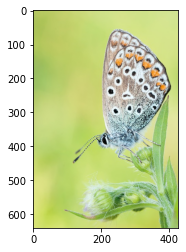

(640, 426, 3)


In [2]:

image = cv2.imread(r'C:/Users/beyza/Downloads/archive (2)/Animal Image Dataset/train/butterfly/e030b2092be90021d85a5854ee454296eb70e3c818b413449df6c87ca3ed_640.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


plt.imshow(image)
plt.show()

print(image.shape)

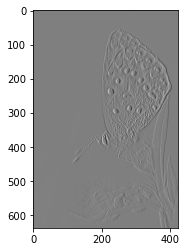

(638, 424, 1)


In [3]:
nb_channels = image.shape[2]
output_channels = 1


image_tensor = torch.from_numpy(image.astype(np.float32)).permute(2,0,1)


weights = torch.tensor([[-1., 0., 1.],
                        [-1., 0., 1.],
                        [-1., 0., 1.]])
weights = weights.view(1,1, 3, 3).repeat(output_channels,nb_channels, 1, 1)


output = F.conv2d(image_tensor.unsqueeze_(0), weights)
output_image = output[0].permute(1, 2, 0).numpy()

plt.imshow(output_image, cmap='binary')
plt.show()

print(output_image.shape)

In [4]:
class AnimalDataset(Dataset):
    def __init__(self, input_size = (128,128), training=True):
        self.input_size = input_size
        
        self.transform = transforms.Compose([transforms.ToTensor()])
        
        
        if training:
            path = r'C:/Users/beyza/Downloads/archive (2)/Animal Image Dataset/train'
        else:
            path = r'C:/Users/beyza/Downloads/archive (2)/Animal Image Dataset/test'
            
        
        self.classes = os.listdir(path)
        files = []
        labels = np.zeros((0,1))
        for cls in self.classes:
            new_files = [path + '\\' + cls + '\\' + x for x in os.listdir(path + '\\' + cls)]
            files.extend(new_files)
            new_labels = np.full((len(new_files),1),self.classes.index(cls))
            labels = np.vstack((labels,new_labels))
        self.data = np.hstack((np.array(files).reshape(-1,1),labels))
        
        np.random.shuffle(self.data)

    def __len__(self):
        return self.data.shape[0]
    
    
    def __getitem__(self, idx):
        
        image = cv2.imread(self.data[idx,0],0)
        
        image = cv2.resize(image,(128,128))
        
        label = self.data[idx,1]
        
        label = np.array(label.astype(np.float32), dtype=np.long)
        return self.transform(image).to(device), torch.from_numpy(label).to(device).long()

training_data = AnimalDataset()
test_data = AnimalDataset(training=False)

training_generator = DataLoader(training_data, batch_size=16)
test_generator = DataLoader(test_data, batch_size=16)

In [5]:
class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 5, (5,5)) 
        self.pool = nn.MaxPool2d((2, 2)) 
        self.conv2 = nn.Conv2d(5, 20, (5,5))
        self.fc1 = nn.Linear(20 * 29 * 29, 32) 
        self.fc2 = nn.Linear(32, 12)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) 
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [17]:
net2 = Net2().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net2.parameters())
epochs = 6
losses=[]
validation_losses=[]
for epoch in range(epochs):
    net2.train()
    loss_sum = 0
    for i, (img, label) in enumerate(training_generator):
        img = img
        label = label
        optimizer.zero_grad()
        outputs = net2(img)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()
        print(f"Epoch {epoch+1}/{epochs}\tLoss:{loss_sum/(i+1):.4f}\t({100*(i+1)/len(training_generator):.0f}%)", end='\r')
    losses.append(loss_sum/len(training_generator))
    net2.eval()
    valid_loss = 0
    with torch.no_grad():
        for i, (img, label) in enumerate(test_generator):
            img = img
            label = label
            outputs = net2(img)
            loss = criterion(outputs, label)
            valid_loss += loss.item()
          
        validation_losses.append(valid_loss/len(test_generator)) 
    print(f"Epoch {epoch+1}/{epochs}\tLoss:{loss_sum/len(training_generator):.4f}\tValidation Loss:{valid_loss/len(test_generator):.4f}")

Epoch 1/6	Loss:2.2985	Validation Loss:2.1212
Epoch 2/6	Loss:2.0760	Validation Loss:2.0018
Epoch 3/6	Loss:1.9150	Validation Loss:1.8327
Epoch 4/6	Loss:1.7698	Validation Loss:1.7710
Epoch 5/6	Loss:1.6395	Validation Loss:1.7841
Epoch 6/6	Loss:1.5369	Validation Loss:1.8026


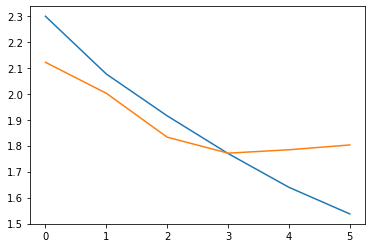

In [18]:
plt.plot(losses)
plt.plot(validation_losses)

In [19]:


correct =0
total=0



with torch.no_grad():
    for i, (img, label) in enumerate(test_generator):
        img = img
        label = label
        outputs = net2(img)
        
        for idx, j in enumerate(outputs):
            if torch.argmax(j) == label[idx]:
                correct +=1
            total +=1
    
print(f'accuracy: {round(correct/total, 3)}')

accuracy: 0.399
